![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('workingday').total.mean()


workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [8]:
bikes[['workingday','hour','total']].describe()

,workingday,hour,total
count,10886.000000,10886.000000,10886.000000
mean,0.680875,11.541613,191.574132
std,0.466159,6.915838,181.144454
min,0.000000,0.000000,1.000000
25%,0.000000,6.000000,42.000000
50%,1.000000,12.000000,145.000000
75%,1.000000,18.000000,284.000000
max,1.000000,23.000000,977.000000


In [9]:
bikes.workingday.value_counts().nunique

# '''
# En los datos se evidencia que cuando workingday es 1 (no es ni fin de semana ni vacaciones) no hay una diferencia muy grande en cuanto al arriendo de motos  con los
# dias en que son fines de semana y vacaciones hay una los dias habiles corresponden a 2.1 veces los dias no habiles, esto nos da un contexto para comprender bien los datos
# '''

<bound method IndexOpsMixin.nunique of 1    7412
0    3474
Name: workingday, dtype: int64>

In [10]:
bikes.hour.value_counts().nunique

# '''
# el segmento de horas mas frecuentes para renta de motos es entre las 12 y 23 horas
# el segundo segmento mas frecuente es entre las 6 y las 11 horas, teniendo que la hora 0 tiene ma misma frecuencia
# '''

<bound method IndexOpsMixin.nunique of 12    456
13    456
22    456
21    456
20    456
19    456
18    456
17    456
16    456
15    456
14    456
23    456
11    455
10    455
9     455
8     455
7     455
6     455
0     455
1     454
5     452
2     448
4     442
3     433
Name: hour, dtype: int64>

In [11]:
bikes.total.value_counts()

# '''
# La cantidad de veces que mas se renta una moto son 5 con 169 veces, seguido por 4, 3, 6, 2 veces, lo que 
# '''

5      169
4      149
3      144
6      135
2      132
      ... 
801      1
629      1
825      1
589      1
636      1
Name: total, Length: 822, dtype: int64

In [12]:
bikes.pivot_table(columns=['workingday'],index='hour',values='total', aggfunc=np.mean)

# A continuacion se evidencia que en general los dias no habiles hay un numero mayor de renta en los segmentos entre las 0 y 4 horas, las 10 y 16 horas, 23 y 0 horas, con respecto a 
# los mismos segmentos en los dias habiles, sin embargo, se nota que, en los segmentos de alto flujo de personas en en horario donde normalmente se toma horarios laborales o actividad
# desplazamientos por actividad social hay unos picos muy alto de rentas de motos, los segmentos de 5 a 9, y de 17 a 22

# Las horas donde se tiene una relacion con respecto a los dias habiles de 4.2754, a la hora 8
# En el segmento de la tarde la hora con mayor pico en los dias habiles tiene una relacion de de 1.56 a favor de la renta en los dias habiles con respecto a los dias no habiles

workingday,0,1
hour,,
0,94.489655,36.732258
1,71.910345,16.003236
2,53.748252,8.436066
3,25.534722,4.892734
4,8.544828,5.363636
5,9.373239,24.529032
6,19.993103,102.577419
7,47.268966,290.690323
8,112.255172,479.945161


In [13]:
bikes.pivot_table(columns=['workingday'],index='hour',values='total', aggfunc=np.mean).sum()

# La diferencia las rentas totales de los dias habiles con respecto a los no habiles es 88.114359, 
# y teniendo encuenta la cantidad dias no habiles vs los habiles (siendo los habiles 2.1 veces superior en cantidad de dias)
# no es una diferencia significante. 

workingday
0    4517.470007
1    4605.584366
dtype: float64

In [14]:
bikes.pivot_table(columns=['workingday'],index='hour',values='total').describe()

# Se nota un comportamiento o tendencia uniforme en los dias no habiles, por otra parte, la renta en los dias habiles es superion en el 25% , sin embargo, en los quartiles 50% y 75%
# la renta en los dias habiles presenta picos superiores, terminado con el maximo que en los dias habiles esta un 1.3 por encima de los dias habiles, a pesar de esto, y como se menciono
# anteriormente, el total de rentas entre los dos tipos de dias, no son significantemente diferentes, siendo superio los dias habiles con en promedio 88 rentas por encima

workingday,0,1
count,24.000000,24.000000
mean,188.227917,191.899349
std,138.425065,154.949456
min,8.544828,4.892734
25%,67.369822,75.930653
50%,163.331034,182.610932
75%,328.820690,259.695089
max,387.820690,529.209003


In [15]:
bikes.pivot_table(index=['workingday'],columns='hour',values='total', aggfunc=np.mean).describe()

# Las horas que pressentan valores pico mas alto son las 8 con 479.945161 y las 17 con 529.209003

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,65.610957,43.956791,31.092159,15.213728,6.954232,16.951136,61.285261,168.979644,296.100167,210.108843,...,279.548797,286.165229,330.057257,434.166571,393.866903,295.813893,216.585120,166.796618,130.847888,89.801841
std,40.840647,39.532296,32.040554,14.596090,2.249442,10.716764,58.395930,172.124892,259.996085,45.516047,...,140.264865,123.797737,53.161729,134.410297,143.710441,75.616677,46.355409,25.538840,10.601176,1.138521
min,36.732258,16.003236,8.436066,4.892734,5.363636,9.373239,19.993103,47.268966,112.255172,177.924138,...,180.366559,198.627010,292.466238,339.124138,292.248276,242.344828,183.806897,148.737931,123.351724,88.996785
25%,51.171607,29.980013,19.764112,10.053231,6.158934,13.162188,40.639182,108.124305,204.177670,194.016491,...,229.957678,242.396119,311.261747,386.645354,343.057590,269.079360,200.196008,157.767275,127.099806,89.399313
50%,65.610957,43.956791,31.092159,15.213728,6.954232,16.951136,61.285261,168.979644,296.100167,210.108843,...,279.548797,286.165229,330.057257,434.166571,393.866903,295.813893,216.585120,166.796618,130.847888,89.801841
75%,80.050306,57.933568,42.420205,20.374225,7.749530,20.740084,81.931340,229.834983,388.022664,226.201196,...,329.139916,329.934339,348.852766,481.687787,444.676217,322.548426,232.974232,175.825962,134.595970,90.204369
max,94.489655,71.910345,53.748252,25.534722,8.544828,24.529032,102.577419,290.690323,479.945161,242.293548,...,378.731034,373.703448,367.648276,529.209003,495.485531,349.282958,249.363344,184.855305,138.344051,90.606897


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

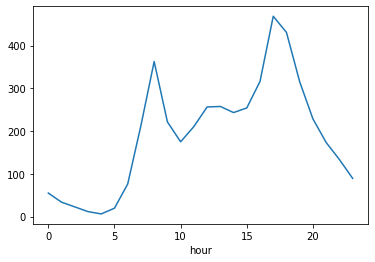

In [16]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

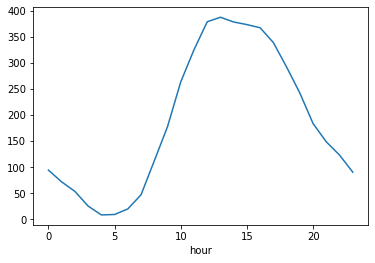

In [22]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday']==0].groupby('hour').total.mean().plot()

# Cuando "workingday"=0 que equivale a dias no habiles se evidencia un mayor flujo de rentas en el segmento comprendido entre las 11 horas y las 17 horas, 
# manteniendose en dicho segmento por encima de 300 rentas, y ya para los demas segmentos el numero de rentas baja dramaticamente, lo que nos dice del comportamiento
# de los usuarios en sus dias libres, usando las motos en todo el transcurso de la tarde, mostrnado menos interes en la noche y madrugada

<AxesSubplot:xlabel='hour'>

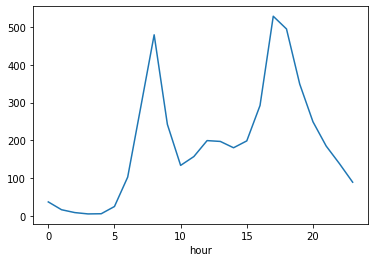

In [23]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday']==1].groupby('hour').total.mean().plot()
# esta grafica es un reflejo del comportamiento de la grafica completa, pues to que se mantinen los dos picos maximos en la jornada de la manana llegando a su pico a las 8 horas
# con un valor total de rentas de 479.945161, donde antes de esa hora sube dramaticamnte y despues baja dramaticamente, siendo asi las 8 horas el momento en que la mayoria de los
# usuarios comienzan su jornada laboral, por otro lado, en las horas de la tarde se tiene que, se tiene un pico maxmimo a las 17 529.209003 y una leve caida a las 18 495.485531, 
# luego a las 19 horas baja hasta 349.282958 y despues de eso se da un bajon dramatico en la cantidad de ususarios, manteniendose en general debajo de 200 rentas durante el resto del dia

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [63]:
# Celda 3
X_df=bikes[['hour','workingday']]
y_df=bikes[['total']]

XTotal=X_df.to_numpy()
yTotal=y_df.to_numpy()

XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

regLin = LinearRegression()
regLin.fit(XTrain,yTrain)
regLin.score(XTrain,yTrain)
prediccion_Lin=regLin.predict(XTest)
MSE_Lin=np.average(np.square(prediccion_Lin-yTest))
print('Coeficientes: \n', regLin.coef_,'\n')
print('Predicciones: \n', prediccion_Lin,'\n')
print('Error cuadratico Medio: \n', MSE_Lin,'\n')

Coeficientes: 
 [[10.55099422  6.770441  ]] 

Predicciones: 
 [[291.86827302]
 [239.11330194]
 [239.11330194]
 ...
 [228.56230772]
 [312.97026145]
 [196.90932507]] 

Error cuadratico Medio: 
 27657.435595059633 



##### En este caso la regresion lineal puede presentar varias limitaciones, este modelo se ve afectado por los datos atipicos y los valores nulos.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [80]:
# Celda 4

# Separación de variables predictoras (X) y variable de interes (y)
X = bikes[['hour','workingday']]
y = (bikes.total > 145).astype(int)

# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [87]:
splits = np.percentile(X.iloc[:, 0], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([ 0.,  2.,  4.,  7.,  9., 12., 14., 16., 19., 21.])

In [88]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 8.0, 0.16178755449047394)

In [90]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

y.shape[0], y_l.shape[0], y_r.shape[0]

(10886, 3594, 7292)

In [91]:
y.mean(), y_l.mean(), y_r.mean()

(0.49917325004593055, 0.09404563160823595, 0.6988480526604498)

In [92]:

tree=tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree

{'y_pred': 0,
 'y_prob': 0.49917340191036,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 0.16178755449047394,
 'sl': {'y_pred': 0,
  'y_prob': 0.0942714126807564,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 0.06425451863089747,
  'sl': {'y_pred': 0,
   'y_prob': 0.026106335561922954,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 0.0027878761479700337,
   'sl': {'y_pred': 0,
    'y_prob': 0.010796723752792257,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 0.0008089140964271449},
   'sr': {'y_pred': 0,
    'y_prob': 0.11816192560175055,
    'level': 3,
    'split': [1, 1.0],
    'n_samples': 455,
    'gain': 0.012693028347051799,
    'sl': {'y_pred': 0,
     'y_prob': 0.006802721088435374,
     'level': 4,
     'split': -1,
     'n_samples': 145,
     'gain': 0},
    'sr': {'y_pred': 0,
     'y_prob': 0.17307692307692307,
     'level': 4,
     'split': -1,
     'n_samples': 310,
     'gain': 0}}},
  'sr'

In [93]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [105]:
# Ejecución de función tree_predict
predicion_arbol=tree_predict(X, tree)
predicion_arbol

array([0., 0., 0., ..., 1., 0., 0.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [113]:
# Celda 5

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
clf.fit(X, y)

DecisionTreeClassifier(max_depth=20, random_state=1)

[Text(0.41964285714285715, 0.9375, 'X[0] <= 6.5\ngini = 0.5\nsamples = 10886\nvalue = [5452, 5434]'),
 Text(0.1326530612244898, 0.8125, 'X[0] <= 5.5\ngini = 0.05\nsamples = 3139\nvalue = [3058, 81]'),
 Text(0.08163265306122448, 0.6875, 'X[0] <= 0.5\ngini = 0.021\nsamples = 2684\nvalue = [2656, 28]'),
 Text(0.04081632653061224, 0.5625, 'X[1] <= 0.5\ngini = 0.104\nsamples = 455\nvalue = [430, 25]'),
 Text(0.02040816326530612, 0.4375, 'gini = 0.267\nsamples = 145\nvalue = [122, 23]'),
 Text(0.061224489795918366, 0.4375, 'gini = 0.013\nsamples = 310\nvalue = [308, 2]'),
 Text(0.12244897959183673, 0.5625, 'X[0] <= 1.5\ngini = 0.003\nsamples = 2229\nvalue = [2226, 3]'),
 Text(0.10204081632653061, 0.4375, 'X[1] <= 0.5\ngini = 0.013\nsamples = 454\nvalue = [451, 3]'),
 Text(0.08163265306122448, 0.3125, 'gini = 0.041\nsamples = 145\nvalue = [142, 3]'),
 Text(0.12244897959183673, 0.3125, 'gini = 0.0\nsamples = 309\nvalue = [309, 0]'),
 Text(0.14285714285714285, 0.4375, 'gini = 0.0\nsamples = 177

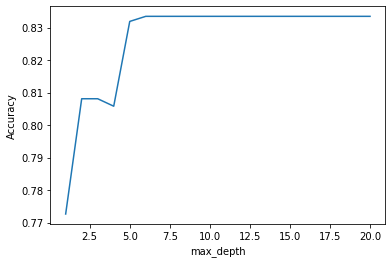

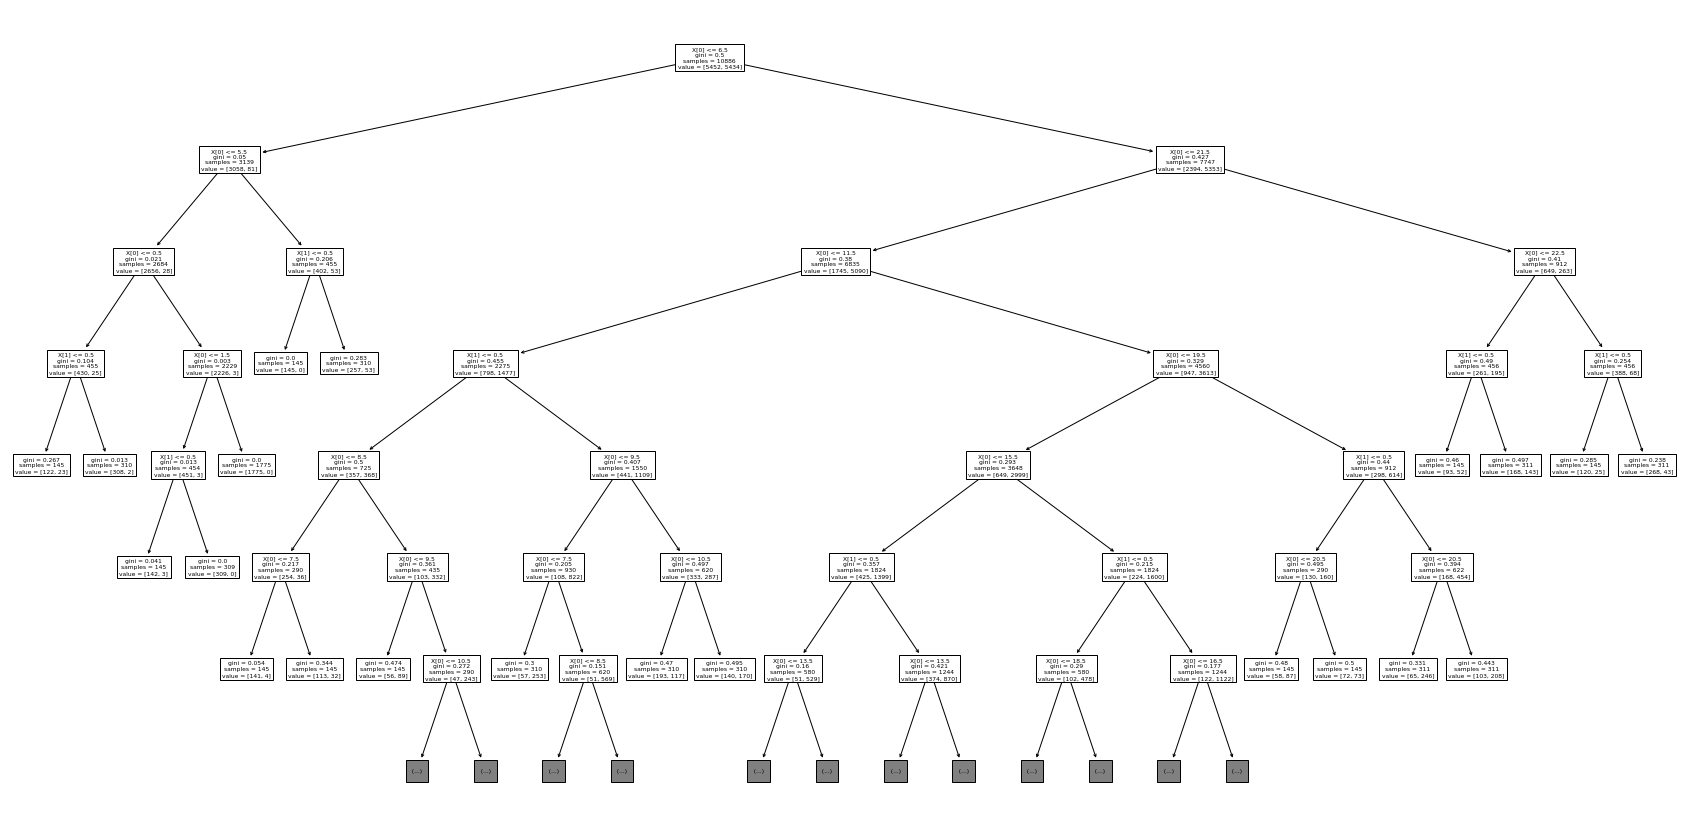

In [116]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.figure(figsize=(30, 15)) 
plot_tree(clf,max_depth=6)

In [117]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8334654195700318, 20)

In [118]:
# max_depth=20 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=20, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=20, random_state=1)

In [120]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':['hour','workingday'], 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
1,workingday,0.037248
0,hour,0.962752


In [121]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.833465
std       0.086944
min       0.700643
25%       0.770495
50%       0.847963
75%       0.900342
max       0.941230
dtype: float64

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [122]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [123]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [131]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

La matriz de predicciones para el arbol de decision es: 

[[402 342]
 [347 409]]
Precision de la prediccion el arbol de decision es: 
 0.5446071904127829
F1_Score: 
 0.5428002654280026 
 Accuracy: 
 0.5406666666666666


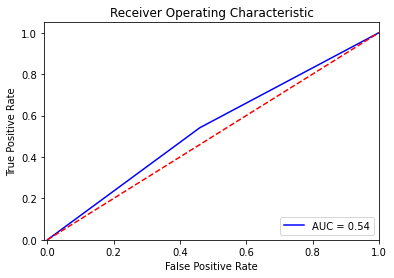

La matriz de predicciones para la regresion logistica es: 

[[483 261]
 [309 447]]
Precision de la prediccion la regresion logistica es: 
 0.6313559322033898
F1_Score: 
 0.610655737704918 
 Accuracy: 
 0.62


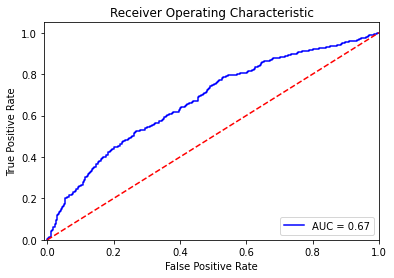

In [154]:
# Celda 6

# Arbol de decision
# Definición del modelo usando DecisionTreeRegressor de sklearn
treeclf = DecisionTreeClassifier(max_depth=None, random_state=123)
treeclf.fit(X_train, y_train)

prediccionestreeclf=treeclf.predict(X_test)
prediccionesProbtreeclf=treeclf.predict_proba(X_test)

# Matriz de prediccion correspondiente a la prediccion en test
pred_matrix_treeclf=confusion_matrix(y_true=y_test, y_pred=prediccionestreeclf)
print('La matriz de predicciones para el arbol de decision es: \n')
print(pred_matrix_treeclf)

# Precision: la precision de la prediccion test es:
precisiontreeclf=precision_score(y_true=y_test, y_pred=prediccionestreeclf)
print('Precision de la prediccion el arbol de decision es: \n', precisiontreeclf)

# Metricas
print('F1_Score: \n', metrics.f1_score(prediccionestreeclf, y_test), '\n Accuracy: \n',metrics.accuracy_score(prediccionestreeclf, y_test))

# La curva ROC y AUC son:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionesProbtreeclf[:,1], pos_label=1)
AUCtreeclf=metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCtreeclf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



# Regresion logistica

RegLog= LogisticRegression(random_state=0,max_iter=10000)
RegLog.fit(X_train,y_train)

prediccionesRegLog=RegLog.predict(X_test)
prediccionesProbRegLog=RegLog.predict_proba(X_test)


# Matriz de prediccion correspondiente a la prediccion en test
pred_matrix=confusion_matrix(y_true=y_test, y_pred=prediccionesRegLog)
print('La matriz de predicciones para la regresion logistica es: \n')
print(pred_matrix)


# Precision: la precision de la prediccion test es:
precisionRegLog=precision_score(y_true=y_test, y_pred=prediccionesRegLog)
print('Precision de la prediccion la regresion logistica es: \n', precisionRegLog)

# Metricas
print('F1_Score: \n', metrics.f1_score(prediccionesRegLog, y_test), '\n Accuracy: \n',metrics.accuracy_score(prediccionesRegLog, y_test))

# La curva ROC y AUC son:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionesProbRegLog[:,1], pos_label=1)
AUCRegLog=metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRegLog)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [160]:
# Celda 7
# 100 árboles de decisión donde max_depth = None
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('F1 Score \n',metrics.f1_score(y_pred, y_test), '\nAccuracy \n',metrics.accuracy_score(y_pred, y_test))


F1 Score 
 0.642384105960265 
Accuracy 
 0.64


In [161]:
# 100 árboles de decisión donde max_depth = 2
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('F1 Score \n',metrics.f1_score(y_pred, y_test), '\nAccuracy \n',metrics.accuracy_score(y_pred, y_test))

F1 Score 
 0.6439545758183033 
Accuracy 
 0.6446666666666667


In [162]:
# 100 regresiones logísticas
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('F1 Score \n',metrics.f1_score(y_pred, y_test), '\nAccuracy \n',metrics.accuracy_score(y_pred, y_test))

F1 Score 
 0.6136210384356034 
Accuracy 
 0.618


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [246]:
# Celda 8
# 100 árboles de decisión donde max_depth = None
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_1=metrics.f1_score(y_pred, y_test)
a_1=metrics.accuracy_score(y_pred, y_test)

print('F1 Score \n',f1_1, '\nAccuracy \n',a_1)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
F1_vp_1=metrics.f1_score(y_pred, y_test)
a_vp_1=metrics.accuracy_score(y_pred, y_test)
# Desempeño al hacer votación ponderada
print('\nDesempeno por votacion ponderada, \nF1 Score: \n',F1_vp_1,'\nAccuracy:\n', a_vp_1)

F1 Score 
 0.642384105960265 
Accuracy 
 0.64

Desempeno por votacion ponderada, 
F1 Score: 
 0.6513761467889909 
Accuracy:
 0.6453333333333333


In [247]:
# 100 árboles de decisión donde max_depth = 2
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_2=metrics.f1_score(y_pred, y_test)
a_2=metrics.accuracy_score(y_pred, y_test)

print('F1 Score \n',f1_2, '\nAccuracy \n',a_2)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
F1_vp_2=metrics.f1_score(y_pred, y_test)
a_vp_2=metrics.accuracy_score(y_pred, y_test)
# Desempeño al hacer votación ponderada
print('\nDesempeno por votacion ponderada, \nF1 Score: \n',F1_vp_2,'\nAccuracy:\n', a_vp_2)

F1 Score 
 0.6439545758183033 
Accuracy 
 0.6446666666666667

Desempeno por votacion ponderada, 
F1 Score: 
 0.6448598130841121 
Accuracy:
 0.6453333333333333


In [248]:
# 100 regresiones logísticas
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_3=metrics.f1_score(y_pred, y_test)
a_3=metrics.accuracy_score(y_pred, y_test)

print('F1 Score \n',f1_3, '\nAccuracy \n',a_3)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
F1_vp_3=metrics.f1_score(y_pred, y_test)
a_vp_3=metrics.accuracy_score(y_pred, y_test)
# Desempeño al hacer votación ponderada
print('\nDesempeno por votacion ponderada, \nF1 Score: \n',F1_vp_3,'\nAccuracy:\n', a_vp_3)

F1 Score 
 0.6136210384356034 
Accuracy 
 0.618

Desempeno por votacion ponderada, 
F1 Score: 
 0.6141414141414142 
Accuracy:
 0.618


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

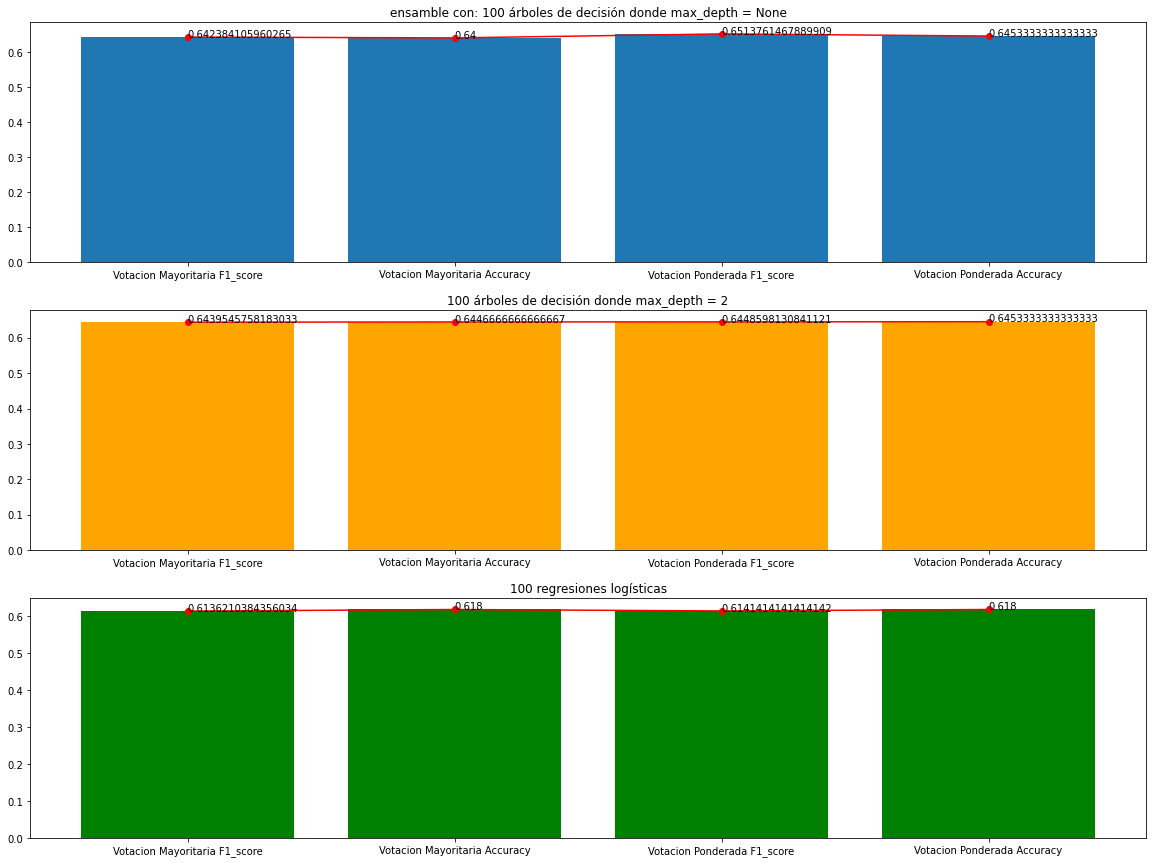

In [249]:
# Celda 9

# Para el caso 1 se tiene que:

fig = plt.figure(figsize=(20,15))
ax1=plt.subplot(3,1,1)


ejeX = ['Votacion Mayoritaria F1_score','Votacion Mayoritaria Accuracy', 'Votacion Ponderada F1_score', 'Votacion Ponderada Accuracy']
ejeY = [f1_1,a_1,F1_vp_1,a_vp_1]
plt.bar(ejeX,ejeY)
ax1.plot(ejeX,ejeY,marker='o', color= 'red')
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.title("ensamble con: 100 árboles de decisión donde max_depth = None")

ax2=plt.subplot(3,1,2)


ejeX = ['Votacion Mayoritaria F1_score','Votacion Mayoritaria Accuracy', 'Votacion Ponderada F1_score', 'Votacion Ponderada Accuracy']
ejeY = [f1_2,a_2,F1_vp_2,a_vp_2]
plt.bar(ejeX,ejeY)
ax2.bar(ejeX,ejeY,color='orange')
ax2.plot(ejeX,ejeY,marker='o', color= 'red')

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.title("100 árboles de decisión donde max_depth = 2")

ax3=plt.subplot(3,1,3)


ejeX = ['Votacion Mayoritaria F1_score','Votacion Mayoritaria Accuracy', 'Votacion Ponderada F1_score', 'Votacion Ponderada Accuracy']
ejeY = [f1_3,a_3,F1_vp_3,a_vp_3]
plt.bar(ejeX,ejeY)
ax3.bar(ejeX,ejeY,color='green')
ax3.plot(ejeX,ejeY,marker='o', color= 'red')

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.title("100 regresiones logísticas")

plt.show()

In [ ]:
# Para el caso 1 ensamble con: 100 árboles de decisión donde max_depth = None, se encontro que con la votacion ponderada se mejoraron las metricas F1 Score y Acuracy, 
# obteniendo asilas mejores metricas de todos los casos, ya que a esta se le debe agregar que el max_depth=None influyo en el desempeno del modelo, en general este 
# comportamiento de la votacion ponderada se mantuvo en los demas casos, lo que cambio para tener un mejor score en general, fue la configuracion del estimador base del 
# bagging, ya que para el segundo caso max_depth = 2, y para el tercer caso el estimador base fue la regresion logistica.
# Cabe mencionar, que para el emsable bagging los estimadores base que tiene mejor comportamiento son los arboles y sus derivados, ya que permite que los arboles crezcan profundamente
# para obtener un sesgo bajo y una varianza alta. Por otra parte, el metodo bagging no es tan efectivo con modelos de baja varianza, en este caso la regresion logistica tiene varianza
# menor que el arbol de decision. 

# La razon mas importante de usar un arbol de decision con bagging es por Una ventaja que ya sabemos que tienen los árboles de decisión es su fácil interpretabilidad. 
# En un árbol resulta evidente cuales son los predictores más influyentes. Al utilizar bagging se mejora (mucho) la predicción, pero se pierde la interpretabilidad. 

# Con respecto a la mejor forma de combinar las predicciones de los modelos utilizados, tuvo un mejor comportamiento la votacion ponderada

# Una de las ventajas en usar un arbol de decision en los Bagging es que no se ven muy afectados po datos atipicos en la informacion.
# Si no existe varianza en el conjunto de datos, la tecninca bagging no mejora significativamente el modelo
# Minestras mas inestable sea el modelo, mejor la prediccion al usar Bagging
# Mejora la predicción, ya que lo que no detecta un modelo lo detectan los otros. *No mejora significativamente las funciones lineales, 
# ya que el ensamble de una función lineal da como resultado otra función lineal
# Una ventaja adicional del bagging es que permite estimar el error de la predicción de forma directa, 
# sin necesidad de utilizar una muestra de test o de aplicar validación cruzada u, otra vez, remuestreo, y se obtiene un resultado similar al que obtendríamos con estos métodos.

# Una desventaja es que Una desventaja del bagging es que introduce una pérdida de interpretabilidad de un modelo. 
# El modelo resultante puede experimentar muchos sesgos cuando se ignora el procedimiento adecuado. 
# A pesar de que el bagging es muy preciso, puede ser costoso desde el punto de vista computacional, lo que puede desaconsejar su uso en determinados casos.